In [1]:
# export PYSPARK_PYTHON=/usr/bin/python3

In [2]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark import SparkContext

In [3]:
sc = SparkContext()
sqlContext = SQLContext(sc)

In [4]:
dataPath = '../Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv'

crimeDataSchema = StructType([StructField("IncidntNum", LongType(), True),
                              StructField("Category", StringType(), True),
                              StructField("Descript", StringType(), True),
                              StructField("DayOfWeek", StringType(), True),
                              StructField("Date", StringType(), True),
                              StructField("Time", StringType(), True),
                              StructField("PdDistrict", StringType(), True),
                              StructField("Resolution", StringType(), True),
                              StructField("Address", StringType(), True),
                              StructField("X", DoubleType(), True),
                              StructField("Y", DoubleType(), True),
                              StructField("Location", StringType(), True),
                              StructField("PdId", LongType(), True)])

crimeDF = (sqlContext.read
           .format('csv')
           .option('delimiter', ',')
           .option('header', 'true')
           .load(dataPath, schema=crimeDataSchema)
           .cache())

# crimeDF.take(1)

# Visualizations

## 1 Counts of Different Crimes
Let's first understand what types of crimes there are, and the frequencies of each.

### 1.1 Overall Trends

In [5]:
crime_types = crimeDF.groupBy('Category').count()
category_rows = crime_types.select('Category', 'Count').orderBy('Count', ascending=True).collect()

In [6]:
category_counts = [(row.Category, row.Count) for row in category_rows]
# print(category_counts)

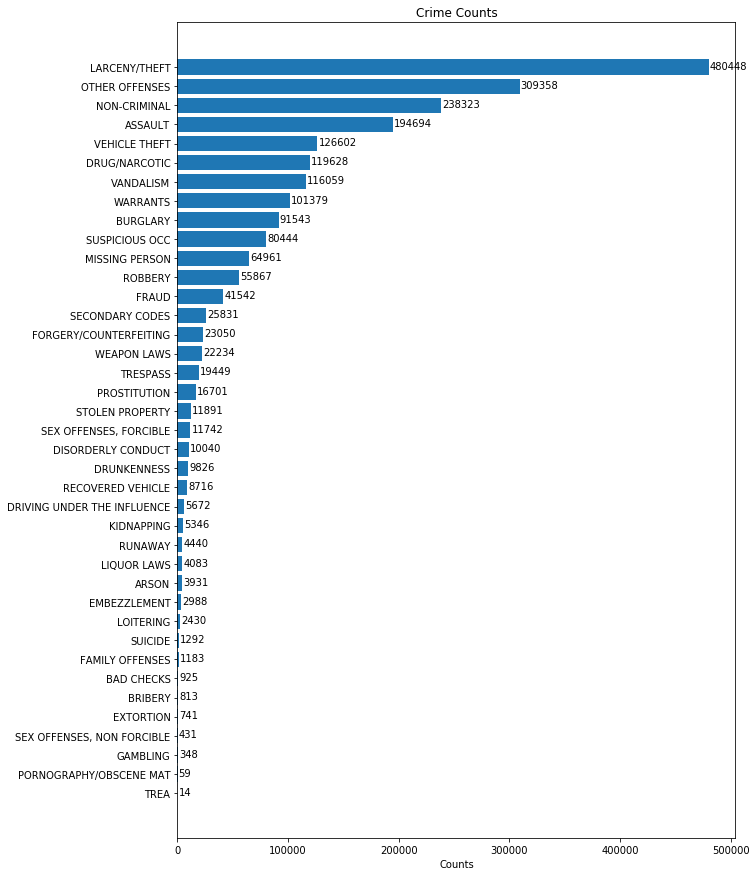

In [42]:
import matplotlib.pyplot as plt
import numpy as np

cats = [r[0] for r in category_counts]
vals = [r[1] for r in category_counts]

plt.figure(figsize=(10,15))
plt.barh(np.arange(len(cats)), vals, align='center')
plt.yticks(np.arange(len(cats)), cats)
plt.title('Crime Counts')
plt.xlabel('Counts')

for i, val in enumerate(vals):
    plt.text(val+1000, i-0.1, str(val))

plt.show()

### 1.2 Most Popular Crimes Per District

In [8]:
crimes = (crimeDF.groupBy('Category')
          .count()
          .select('Category')
          .orderBy('Count', ascending=False)
          .collect())
crimes = [row.Category for row in crimes]
print("Crimes: ", crimes)

districts = (crimeDF.groupBy('PdDistrict')
             .count()
             .select('PdDistrict')
             .collect())
districts = [row.PdDistrict for row in districts if row.PdDistrict is not None]
print("Districts: ", districts)

category_district_count = (crimeDF.groupBy('Category', 'PdDistrict')
                           .count()
                           .select('Category', 'PdDistrict', 'Count')
                           .collect())
category_district_count = [(r.Category, r.PdDistrict, r.Count) for r in category_district_count]
# print(category_district_count)

Crimes:  ['LARCENY/THEFT', 'OTHER OFFENSES', 'NON-CRIMINAL', 'ASSAULT', 'VEHICLE THEFT', 'DRUG/NARCOTIC', 'VANDALISM', 'WARRANTS', 'BURGLARY', 'SUSPICIOUS OCC', 'MISSING PERSON', 'ROBBERY', 'FRAUD', 'SECONDARY CODES', 'FORGERY/COUNTERFEITING', 'WEAPON LAWS', 'TRESPASS', 'PROSTITUTION', 'STOLEN PROPERTY', 'SEX OFFENSES, FORCIBLE', 'DISORDERLY CONDUCT', 'DRUNKENNESS', 'RECOVERED VEHICLE', 'DRIVING UNDER THE INFLUENCE', 'KIDNAPPING', 'RUNAWAY', 'LIQUOR LAWS', 'ARSON', 'EMBEZZLEMENT', 'LOITERING', 'SUICIDE', 'FAMILY OFFENSES', 'BAD CHECKS', 'BRIBERY', 'EXTORTION', 'SEX OFFENSES, NON FORCIBLE', 'GAMBLING', 'PORNOGRAPHY/OBSCENE MAT', 'TREA']
Districts:  ['MISSION', 'BAYVIEW', 'CENTRAL', 'TARAVAL', 'TENDERLOIN', 'INGLESIDE', 'PARK', 'SOUTHERN', 'RICHMOND', 'NORTHERN']


In [9]:
# Create mapping from text to num for 2d heatmap
crime_index = {crime: index for (index, crime) in enumerate(crimes)}
# print(crime_index)

district_index = {district: index for (index, district) in enumerate(districts)}
# print(district_index)

In [10]:
heatmap_grid = np.zeros([len(crimes), len(districts)])

for (crime, dist, count) in category_district_count:
    if not dist is None:
        heatmap_grid[crime_index[crime]][district_index[dist]] = count    
    
# print(heatmap_grid)    

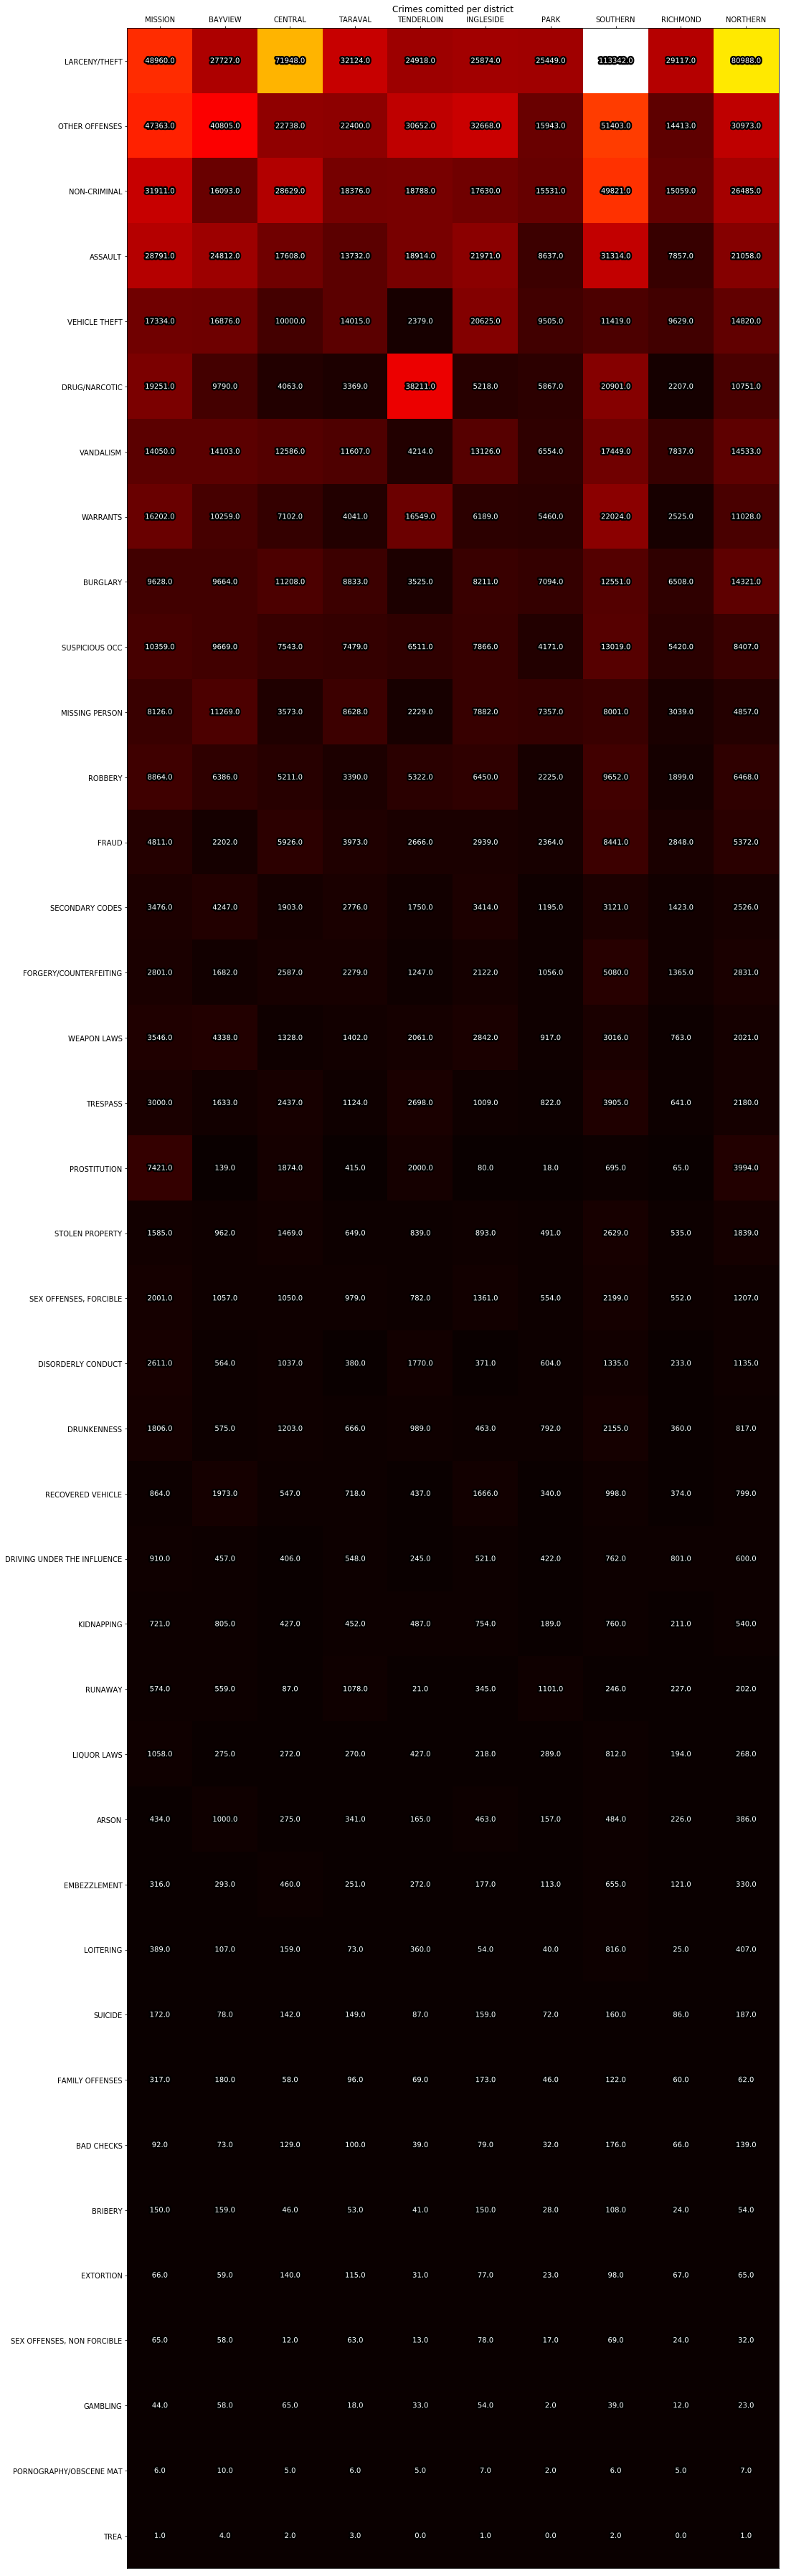

In [11]:
import matplotlib.patheffects as PathEffects

fig, ax = plt.subplots(figsize=(30, 50))
im = ax.imshow(heatmap_grid, cmap='hot')

ax.set_xticks(np.arange(len(districts)))
ax.set_yticks(np.arange(len(crimes)))

ax.set_xticklabels(districts)
ax.set_yticklabels(crimes)
ax.xaxis.tick_top()

plt.setp(ax.get_xticklabels(), ha="center")

for i in range(len(crimes)):
    for j in range(len(districts)):
        text = ax.text(j, i, heatmap_grid[i, j],
                       ha="center", va="center", color="w")
        text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='black')])

ax.set_title("Crimes comitted per district")
fig.tight_layout()
plt.show()

## 2 How Crimes Fluctuate over Time

In [19]:
# First cache a DF with an actual date object
from pyspark.sql.functions import udf
import datetime

def parseDate(dateStr):
    tokens = dateStr.split("/")
    month = int(tokens[0])
    date = int(tokens[1])
    year = int(tokens[2])
    return datetime.date(year, month, date)

date_udf = udf(parseDate, DateType())

crime_with_date = (crimeDF.withColumn("Date_tmp", date_udf(crimeDF.Date))
         .drop("Date")
         .withColumnRenamed("Date_tmp", "Date")
         .select("Category", "Date", "PdDistrict")
         .cache())
crime_with_date.printSchema()
crime_with_date.take(5)

root
 |-- Category: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- PdDistrict: string (nullable = true)



[Row(Category='NON-CRIMINAL', Date=datetime.date(2015, 1, 19), PdDistrict='MISSION'),
 Row(Category='ROBBERY', Date=datetime.date(2015, 2, 1), PdDistrict='TENDERLOIN'),
 Row(Category='ASSAULT', Date=datetime.date(2015, 2, 1), PdDistrict='TENDERLOIN'),
 Row(Category='SECONDARY CODES', Date=datetime.date(2015, 2, 1), PdDistrict='TENDERLOIN'),
 Row(Category='VANDALISM', Date=datetime.date(2015, 1, 27), PdDistrict='NORTHERN')]

### 2.1 Yearly Trends

In [76]:
extrat_year_udf = udf(lambda datetime: datetime.year, LongType())

crime_with_year = (crime_with_date
                   .withColumn("Year", extrat_year_udf(crime_with_date.Date))
                   .groupBy("Year", "Category", "PdDistrict")
                   .count()
                   .select("Year", "Category", "PdDistrict", "Count")
                   .orderBy("Year", ascending=True)
                   .cache())
crime_with_year.take(10)
# print(len(crime_with_year.collect()))

[Row(Year=2003, Category='NON-CRIMINAL', PdDistrict='PARK', Count=660),
 Row(Year=2003, Category='KIDNAPPING', PdDistrict='TARAVAL', Count=26),
 Row(Year=2003, Category='VEHICLE THEFT', PdDistrict='SOUTHERN', Count=1426),
 Row(Year=2003, Category='DRUG/NARCOTIC', PdDistrict='PARK', Count=383),
 Row(Year=2003, Category='TRESPASS', PdDistrict='TENDERLOIN', Count=136),
 Row(Year=2003, Category='KIDNAPPING', PdDistrict='TENDERLOIN', Count=38),
 Row(Year=2003, Category='BAD CHECKS', PdDistrict='SOUTHERN', Count=34),
 Row(Year=2003, Category='DRIVING UNDER THE INFLUENCE', PdDistrict='RICHMOND', Count=30),
 Row(Year=2003, Category='EMBEZZLEMENT', PdDistrict='NORTHERN', Count=30),
 Row(Year=2003, Category='BAD CHECKS', PdDistrict='TENDERLOIN', Count=6)]

In [ ]:
from matplotlib.ticker import MaxNLocator
x = range(2003, 2019) #17 years of data, [2003, 2019)

fig = plt.figure(figsize=(15, 100))
for i, crime in enumerate(crimes):
    y = []
    
    for district in districts:
        district_crime_counts = [0]*(2019-2003)

#         district_crime_count_by_year = (crime_with_year
#                                         .filter(crime_with_year.PdDistrict == district)
#                                         .filter(crime_with_year.Category == crime)
#                                         .collect())
#         for year_row in district_crime_count_by_year:
#             district_crime_counts[year_row.Year-2003] = year_row.Count

        y.append(district_crime_counts)
        
    fig.add_subplot(20,2,i+1)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.stackplot(x, y, labels=districts)
    plt.legend(loc='upper left')
    plt.title(crime)
    plt.ylabel("Counts")
    plt.xlabel("Year")
plt.show()
# print(y)

### 2.2 Monthly Trends

### 2.3 Day of the Week Trends

### 2.4 Hourly Trends

In [ ]:
# Parse the date and extra the year


## 3 Different Crimes Per Location